![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

### Stakeholders: small real estate company who advises families on selling their homes
### Pain points: 

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [446]:
# import relevant libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [447]:
data = pd.read_csv('../../data/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [448]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

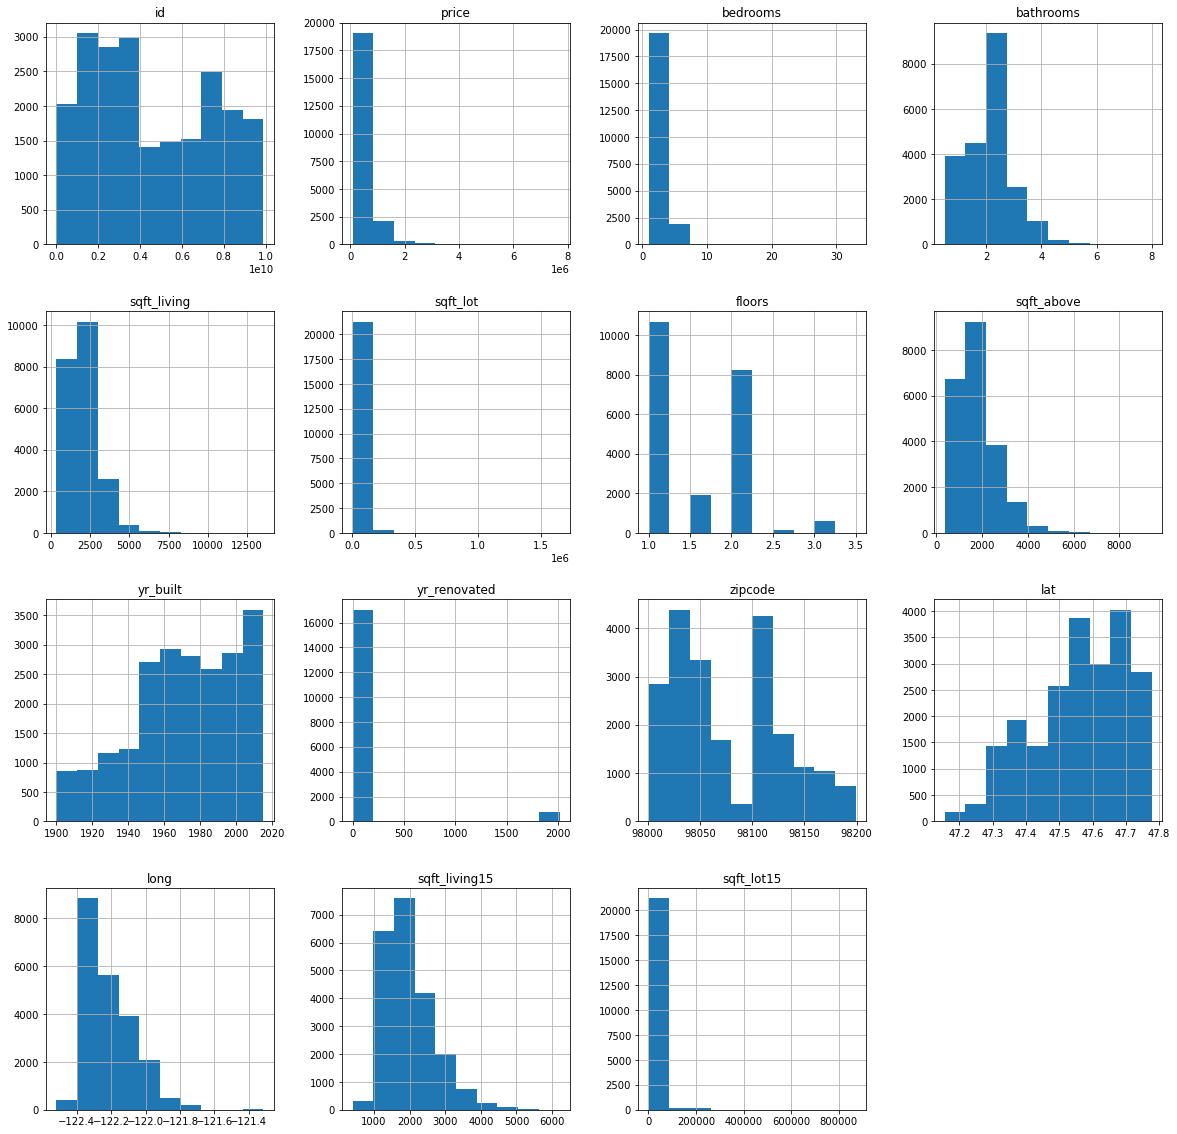

In [449]:
data.hist(figsize=(20,20));

Some of these features look like they could use some log processing.

In [450]:
datalog = pd.DataFrame()
log_cols = ['id','price','sqft_living','sqft_lot','sqft_above']
for col in log_cols:
    if col == 'id':
        datalog[col] = data[col]
        continue
    datalog[f'{col}_log'] = data[col].map(lambda x: np.log(x))

In [451]:
data = pd.merge(data,datalog,on='id')

In [452]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log'],
      dtype='object')

In [453]:
data['sqft_basement'].value_counts()

0.0       13047
?           458
600.0       219
500.0       215
700.0       213
          ...  
3000.0        1
2730.0        1
243.0         1
1852.0        1
172.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [454]:
data.loc[data['sqft_basement'] == '?','sqft_basement'] = np.nan

In [455]:
data['sqft_basement'].value_counts()

0.0       13047
600.0       219
500.0       215
700.0       213
800.0       201
          ...  
3000.0        1
2730.0        1
243.0         1
1852.0        1
172.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [456]:
def tryfloat(x):
    try:
        return float(x)
    except:
        return x

In [457]:
data['sqft_basement'] = data['sqft_basement'].map(tryfloat)

In [458]:
rel_cols = ['price', 'price_log', 'grade', 'condition', 'view', 'sqft_living',
            'sqft_living_log', 'sqft_lot', 'sqft_lot_log', 'sqft_above', 'sqft_above_log',
            'sqft_basement', 'bedrooms', 'bathrooms', 'floors']
data = data[rel_cols]

In [459]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21953 entries, 0 to 21952
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21953 non-null  float64
 1   price_log        21953 non-null  float64
 2   grade            21953 non-null  object 
 3   condition        21953 non-null  object 
 4   view             21890 non-null  object 
 5   sqft_living      21953 non-null  int64  
 6   sqft_living_log  21953 non-null  float64
 7   sqft_lot         21953 non-null  int64  
 8   sqft_lot_log     21953 non-null  float64
 9   sqft_above       21953 non-null  int64  
 10  sqft_above_log   21953 non-null  float64
 11  sqft_basement    21495 non-null  float64
 12  bedrooms         21953 non-null  int64  
 13  bathrooms        21953 non-null  float64
 14  floors           21953 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 2.7+ MB


In [460]:
data.describe()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,sqft_basement,bedrooms,bathrooms,floors
count,2.195300e+04,21953.000000,21953.000000,21953.000000,2.195300e+04,21953.000000,21953.000000,21953.000000,21495.000000,21953.000000,21953.000000,21953.000000
mean,5.383009e+05,13.043428,2074.745638,7.547883,1.504273e+04,8.990033,1783.510500,7.392320,291.371063,3.371703,2.110645,1.490366
std,3.666281e+05,0.529114,916.716574,0.424472,4.117921e+04,0.898564,825.902051,0.426929,442.093833,0.928005,0.769513,0.538881
min,7.800000e+04,11.264464,370.000000,5.913503,5.200000e+02,6.253829,370.000000,5.913503,0.000000,1.000000,0.500000,1.000000
25%,3.200000e+05,12.676076,1420.000000,7.258412,5.050000e+03,8.527144,1190.000000,7.081709,0.000000,3.000000,1.500000,1.000000
50%,4.500000e+05,13.017003,1910.000000,7.554859,7.620000e+03,8.938532,1560.000000,7.352441,0.000000,3.000000,2.250000,1.500000
75%,6.410000e+05,13.370785,2540.000000,7.839919,1.066600e+04,9.274816,2200.000000,7.696213,560.000000,4.000000,2.500000,2.000000
max,7.700000e+06,15.856731,13540.000000,9.513404,1.651359e+06,14.317109,9410.000000,9.149528,4820.000000,33.000000,8.000000,3.500000


In [461]:
data['view'].value_counts()

NONE         19762
AVERAGE        959
GOOD           514
FAIR           332
EXCELLENT      323
Name: view, dtype: int64

In [462]:
data['view'].value_counts()[0]/len(data)

0.9001958730014121

In [463]:
# delete 'view' column since not much information given
data.drop(columns='view', inplace=True)

In [464]:
for col in data.columns:
    print(f'\n{col}:\n')
    print(data.sort_values(by=col,ascending=False).head(15))


price:

           price  price_log         grade condition  sqft_living  \
7361   7700000.0  15.856731    13 Mansion      Good        12050   
3976   7060000.0  15.769956  11 Excellent   Average        10040   
9395   6890000.0  15.745582    13 Mansion   Average         9890   
4479   5570000.0  15.532906    13 Mansion   Average         9200   
1470   5350000.0  15.492607     12 Luxury   Average         8000   
1337   5300000.0  15.483217     12 Luxury      Good         7390   
1182   5110000.0  15.446710     12 Luxury   Average         8010   
8209   4670000.0  15.356670     12 Luxury   Average         9640   
2670   4500000.0  15.319588     12 Luxury   Average         6640   
8767   4490000.0  15.317363     12 Luxury   Average         6430   
12576  4210000.0  15.252973     12 Luxury   Average         7440   
4215   4000000.0  15.201805     12 Luxury   Average         7080   
2117   3850000.0  15.163584  11 Excellent      Good         5770   
7140   3800000.0  15.150512    13 Mansi

           price  price_log          grade  condition  sqft_living  \
6785    253905.0  12.444715      7 Average  Very Good          940   
2776    649000.0  13.383188         8 Good  Very Good         2240   
9504    715000.0  13.480038         8 Good  Very Good         2370   
9500    300000.0  12.611538  6 Low Average  Very Good         1100   
9499   1100000.0  13.910821         8 Good  Very Good         3530   
20233   500000.0  13.122363      7 Average  Very Good         2270   
16062   572000.0  13.256894  6 Low Average  Very Good         1850   
9493    598000.0  13.301346      7 Average  Very Good         2420   
9487    501000.0  13.124361      7 Average  Very Good         1010   
9486    335000.0  12.721886  6 Low Average  Very Good         1170   
9479    230000.0  12.345835      7 Average  Very Good         1010   
2795    722500.0  13.490473         8 Good  Very Good         3700   
9472    960000.0  13.774689   10 Very Good  Very Good         3430   
2808    555000.0  13

           price  price_log          grade  condition  sqft_living  \
1747    700000.0  13.458836  6 Low Average       Good         1300   
17615   190000.0  12.154779         5 Fair       Fair          710   
7756    542500.0  13.203943         8 Good  Very Good         3010   
7878    855000.0  13.658857   10 Very Good    Average         4030   
4011    998000.0  13.813509   10 Very Good    Average         3770   
4509    790000.0  13.579788         8 Good    Average         2560   
6791   2000000.0  14.508658      12 Luxury    Average         3900   
7182   1650000.0  14.316286   11 Excellent    Average         3920   
9869    937500.0  13.750972   11 Excellent    Average         5545   
20784  1600000.0  14.285514   11 Excellent    Average         6530   
4608    550000.0  13.217674      7 Average       Good         3650   
13225   750000.0  13.527828       9 Better       Good         2350   
13702   849900.0  13.652874       9 Better    Average         2280   
16470   700000.0  13

           price  price_log         grade  condition  sqft_living  \
8209   4670000.0  15.356670     12 Luxury    Average         9640   
12990  2280000.0  14.639686     12 Luxury    Average        13540   
15750  3200000.0  14.978661     12 Luxury       Good         7000   
7361   7700000.0  15.856731    13 Mansion       Good        12050   
10244  1900000.0  14.457364  11 Excellent       Good         6510   
4479   5570000.0  15.532906    13 Mansion    Average         9200   
5120   1390000.0  14.144814  10 Very Good       Good         5700   
21682  1490000.0  14.214287     12 Luxury    Average         6880   
7140   3800000.0  15.150512    13 Mansion       Good         7050   
6726    850000.0  13.652992      9 Better       Fair         5440   
15303  1540000.0  14.247293      9 Better  Very Good         5770   
2759   1110000.0  13.919871  11 Excellent    Average         7350   
12023  1790000.0  14.397726     12 Luxury    Average         5490   
2120   1200000.0  13.997832  11 Ex

33 bedrooms is pretty crazy and not highly correlated with a high price. I'll remove that one.

In [465]:
data = data[data['bedrooms'] != 33]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


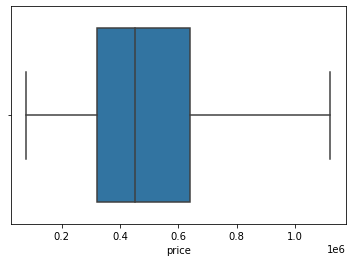

In [466]:
sns.boxplot(data['price'], orient='h', showfliers=False);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


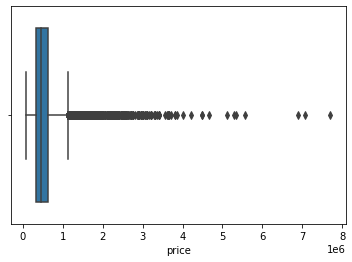

In [467]:
sns.boxplot(data['price'], orient='h');

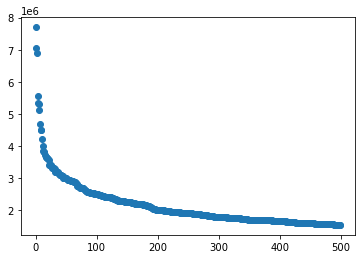

In [468]:
fig, ax = plt.subplots()
ax.scatter(x=range(500), y=data.sort_values('price', ascending=False)['price'][:500])

In [469]:
# homes >= $2 mil are significant outliers, we'll remove them
# Only account for 0.95% of all the data
len(data[data['price'] >= 2000000])/len(data)

0.009475218658892129

In [470]:
len(data)

21952

In [471]:
data = data[data['price'] < 2000000]

In [472]:
len(data)

21744

In [473]:
# sns.pairplot(data);

In [474]:
data.corr()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,sqft_basement,bedrooms,bathrooms,floors
price,1.000000,0.936227,0.680494,0.630590,0.100109,0.145768,0.585621,0.554260,0.287317,0.321967,0.509198,0.280815
price_log,0.936227,1.000000,0.666801,0.655840,0.099695,0.118742,0.570395,0.564786,0.287377,0.336014,0.523887,0.309461
sqft_living,0.680494,0.666801,1.000000,0.962503,0.176890,0.339123,0.867669,0.844958,0.407369,0.595289,0.743191,0.355723
sqft_living_log,0.630590,0.655840,0.962503,1.000000,0.150323,0.316178,0.827160,0.859431,0.407122,0.633572,0.753747,0.364925
sqft_lot,0.100109,0.099695,0.176890,0.150323,1.000000,0.641407,0.186138,0.163899,0.012379,0.033358,0.086919,-0.005970
sqft_lot_log,0.145768,0.118742,0.339123,0.316178,0.641407,1.000000,0.323380,0.309211,0.084050,0.183572,0.085092,-0.243687
sqft_above,0.585621,0.570395,0.867669,0.827160,0.186138,0.323380,1.000000,0.966702,-0.100172,0.484210,0.670239,0.531076
sqft_above_log,0.554260,0.564786,0.844958,0.859431,0.163899,0.309211,0.966702,1.000000,-0.084578,0.522010,0.685990,0.548820
sqft_basement,0.287317,0.287377,0.407369,0.407122,0.012379,0.084050,-0.100172,-0.084578,1.000000,0.302055,0.255954,-0.263216
bedrooms,0.321967,0.336014,0.595289,0.633572,0.033358,0.183572,0.484210,0.522010,0.302055,1.000000,0.518806,0.177265


In [475]:
data.columns

Index(['price', 'price_log', 'grade', 'condition', 'sqft_living',
       'sqft_living_log', 'sqft_lot', 'sqft_lot_log', 'sqft_above',
       'sqft_above_log', 'sqft_basement', 'bedrooms', 'bathrooms', 'floors'],
      dtype='object')

In [476]:
# fig, axes = plt.subplots(5,3, figsize=(20,20))
# for i, col in enumerate(data.columns):
#     sns.histplot(data=data, x=col, kde=True, ax=axes[i//3,i%3]);

### Categorical: 'Grade' to only 4: Low, Average, Above Average, and Excellent

In [477]:
# Lows including 3 Poor, 5 Fair and 6 Low Average
data['grade'].replace('3 Poor','G_Low', inplace=True)
data['grade'].replace('5 Fair','G_Low', inplace=True)
data['grade'].replace('4 Low','G_Low', inplace=True)
data['grade'].replace('6 Low Average','G_Low', inplace=True)

# Average including 7 Average 
data['grade'].replace('7 Average','G_Average', inplace=True)

# Average Above including 8 Good,9 Better
data['grade'].replace('8 Good','G_Above_Ave', inplace=True)
data['grade'].replace('9 Better','G_Above_Ave', inplace=True)

# Excellent including 10 Very Good, 11 Excellent,12 Luxury and 13 Mansion
data['grade'].replace('10 Very Good','G_Excellent', inplace=True)
data['grade'].replace('11 Excellent','G_Excellent', inplace=True)
data['grade'].replace('12 Luxury','G_Excellent', inplace=True)
data['grade'].replace('13 Mansion','G_Excellent', inplace=True)

In [478]:
data['grade'].value_counts(normalize=True)

G_Average      0.420438
G_Above_Ave    0.401076
G_Low          0.110927
G_Excellent    0.067559
Name: grade, dtype: float64

### Categorical: 'Condition' to only 3: Low, Average, and Good

In [479]:
data['condition'].value_counts(normalize=True)

Average      0.649880
Good         0.262003
Very Good    0.078091
Fair         0.008600
Poor         0.001426
Name: condition, dtype: float64

In [480]:
# Poor including Poor and Fair
data['condition'].replace('Poor','Cond_Poor', inplace=True)
data['condition'].replace('Fair','Cond_Poor', inplace=True)


#Average staying the same
data['condition'].replace('Average','Cond_Ave', inplace=True)

# Good including Good and VeryGood
data['condition'].replace('Good','Cond_Good', inplace=True)
data['condition'].replace('Very Good','Cond_Good', inplace=True)

data['condition'].value_counts(normalize=True)

Cond_Ave     0.649880
Cond_Good    0.340094
Cond_Poor    0.010026
Name: condition, dtype: float64

In [481]:
data.groupby(by=['condition','grade']).agg(['mean','count'])['price']

mean  count
condition grade                           
Cond_Ave  G_Above_Ave  5.760704e+05   6342
          G_Average    3.852705e+05   5343
          G_Excellent  1.041207e+06   1233
          G_Low        2.844088e+05   1213
Cond_Good G_Above_Ave  6.924609e+05   2362
          G_Average    4.270746e+05   3712
          G_Excellent  1.204005e+06    235
          G_Low        3.072886e+05   1086
Cond_Poor G_Above_Ave  5.165265e+05     17
          G_Average    3.479407e+05     87
          G_Excellent  9.500000e+05      1
          G_Low        2.537389e+05    113

In [482]:
data.groupby(by=['grade','condition']).agg(['mean','count'])['price']

mean  count
grade       condition                     
G_Above_Ave Cond_Ave   5.760704e+05   6342
            Cond_Good  6.924609e+05   2362
            Cond_Poor  5.165265e+05     17
G_Average   Cond_Ave   3.852705e+05   5343
            Cond_Good  4.270746e+05   3712
            Cond_Poor  3.479407e+05     87
G_Excellent Cond_Ave   1.041207e+06   1233
            Cond_Good  1.204005e+06    235
            Cond_Poor  9.500000e+05      1
G_Low       Cond_Ave   2.844088e+05   1213
            Cond_Good  3.072886e+05   1086
            Cond_Poor  2.537389e+05    113

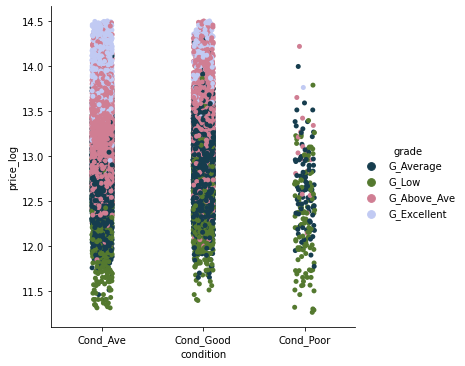

In [483]:
sns.catplot(x='condition',y='price_log', hue = "grade", data=data, palette="cubehelix")

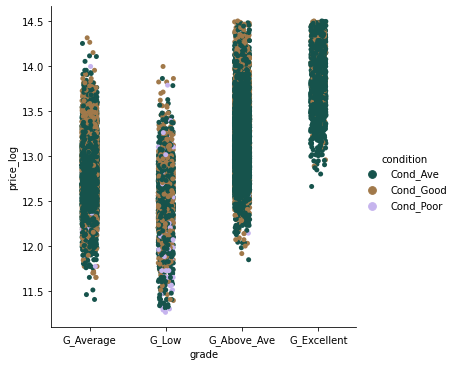

In [484]:
sns.catplot(x='grade',y='price_log', hue = "condition", data=data, palette="cubehelix")

In [485]:
cond = data[["condition"]]
ohe = OneHotEncoder(categories="auto", handle_unknown="error", sparse=False)
ohe.fit(cond)
cond_encod = ohe.transform(cond)
cond_encod = pd.DataFrame(
    # Pass in NumPy array
    cond_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
cond_encod.drop(columns='Cond_Ave', inplace=True)

In [486]:
grade = data[["grade"]]
ohe = OneHotEncoder(categories="auto",handle_unknown="ignore", sparse=False)
ohe.fit(grade)
grade_encod = ohe.transform(grade)
grade_encod = pd.DataFrame(
    # Pass in NumPy array
    grade_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
grade_encod.drop(columns='G_Average', inplace=True)

In [489]:
data = pd.concat([data, cond_encod, grade_encod], axis=1)\
        .drop(columns=['condition','grade'])

### Changing sqft_basement to a binomial variable "has_basement"

In [487]:
# replace sqft_basement with basement: True (1) / False (0)
data['sqft_basement'] = data['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
data.rename(columns={'sqft_basement':'has_basement'}, inplace=True)

In [490]:
data

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
0,221900.0,12.309982,1180,7.073270,5650,8.639411,1180,7.073270,0,3,1.00,1.0,0.0,0.0,0.0,0.0,0.0
1,538000.0,13.195614,2570,7.851661,7242,8.887653,2170,7.682482,1,3,2.25,2.0,0.0,0.0,0.0,0.0,0.0
2,180000.0,12.100712,770,6.646391,10000,9.210340,770,6.646391,0,2,1.00,1.0,0.0,0.0,0.0,0.0,1.0
3,604000.0,13.311329,1960,7.580700,5000,8.517193,1050,6.956545,1,4,3.00,1.0,1.0,0.0,0.0,0.0,0.0
4,510000.0,13.142166,1680,7.426549,8080,8.997147,1680,7.426549,0,3,2.00,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21948,360000.0,12.793859,1530,7.333023,1131,7.030857,1530,7.333023,0,3,2.50,3.0,0.0,0.0,1.0,0.0,0.0
21949,400000.0,12.899220,2310,7.745003,5813,8.667852,2310,7.745003,0,4,2.50,2.0,0.0,0.0,1.0,0.0,0.0
21950,402101.0,12.904459,1020,6.927558,1350,7.207860,1020,6.927558,0,2,0.75,2.0,0.0,0.0,0.0,0.0,0.0
21951,400000.0,12.899220,1600,7.377759,2388,7.778211,1600,7.377759,0,3,2.50,2.0,0.0,0.0,1.0,0.0,0.0


In [491]:
data.corr()

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
price,1.000000,0.936227,0.680494,0.630590,0.100109,0.145768,0.585621,0.554260,0.177112,0.321967,0.509198,0.280815,0.004242,-0.070980,0.257543,0.516302,-0.275929
price_log,0.936227,1.000000,0.666801,0.655840,0.099695,0.118742,0.570395,0.564786,0.200092,0.336014,0.523887,0.309461,-0.002500,-0.103667,0.343397,0.426568,-0.364718
sqft_living,0.680494,0.666801,1.000000,0.962503,0.176890,0.339123,0.867669,0.844958,0.192845,0.595289,0.743191,0.355723,-0.092293,-0.080547,0.321226,0.519972,-0.361876
sqft_living_log,0.630590,0.655840,0.962503,1.000000,0.150323,0.316178,0.827160,0.859431,0.227588,0.633572,0.753747,0.364925,-0.080612,-0.098579,0.384931,0.422416,-0.452830
sqft_lot,0.100109,0.099695,0.176890,0.150323,1.000000,0.641407,0.186138,0.163899,-0.035614,0.033358,0.086919,-0.005970,0.006566,0.035811,0.013757,0.119011,-0.011004
sqft_lot_log,0.145768,0.118742,0.339123,0.316178,0.641407,1.000000,0.323380,0.309211,-0.053514,0.183572,0.085092,-0.243687,0.113662,0.040640,-0.028927,0.209934,-0.004820
sqft_above,0.585621,0.570395,0.867669,0.827160,0.186138,0.323380,1.000000,0.966702,-0.232548,0.484210,0.670239,0.531076,-0.187625,-0.071090,0.319427,0.525104,-0.316764
sqft_above_log,0.554260,0.564786,0.844958,0.859431,0.163899,0.309211,0.966702,1.000000,-0.228505,0.522010,0.685990,0.548820,-0.175193,-0.084439,0.390453,0.438885,-0.394139
has_basement,0.177112,0.200092,0.192845,0.227588,-0.035614,-0.053514,-0.232548,-0.228505,1.000000,0.157254,0.150487,-0.259039,0.117884,-0.020140,0.023927,-0.008903,-0.129167
bedrooms,0.321967,0.336014,0.595289,0.633572,0.033358,0.183572,0.484210,0.522010,0.157254,1.000000,0.518806,0.177265,0.003224,-0.060873,0.186523,0.175079,-0.277972


In [493]:
datafeat = data.drop(columns=['price','price_log'])
datafeat.corr()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
sqft_living,1.000000,0.962503,0.176890,0.339123,0.867669,0.844958,0.192845,0.595289,0.743191,0.355723,-0.092293,-0.080547,0.321226,0.519972,-0.361876
sqft_living_log,0.962503,1.000000,0.150323,0.316178,0.827160,0.859431,0.227588,0.633572,0.753747,0.364925,-0.080612,-0.098579,0.384931,0.422416,-0.452830
sqft_lot,0.176890,0.150323,1.000000,0.641407,0.186138,0.163899,-0.035614,0.033358,0.086919,-0.005970,0.006566,0.035811,0.013757,0.119011,-0.011004
sqft_lot_log,0.339123,0.316178,0.641407,1.000000,0.323380,0.309211,-0.053514,0.183572,0.085092,-0.243687,0.113662,0.040640,-0.028927,0.209934,-0.004820
sqft_above,0.867669,0.827160,0.186138,0.323380,1.000000,0.966702,-0.232548,0.484210,0.670239,0.531076,-0.187625,-0.071090,0.319427,0.525104,-0.316764
sqft_above_log,0.844958,0.859431,0.163899,0.309211,0.966702,1.000000,-0.228505,0.522010,0.685990,0.548820,-0.175193,-0.084439,0.390453,0.438885,-0.394139
has_basement,0.192845,0.227588,-0.035614,-0.053514,-0.232548,-0.228505,1.000000,0.157254,0.150487,-0.259039,0.117884,-0.020140,0.023927,-0.008903,-0.129167
bedrooms,0.595289,0.633572,0.033358,0.183572,0.484210,0.522010,0.157254,1.000000,0.518806,0.177265,0.003224,-0.060873,0.186523,0.175079,-0.277972
bathrooms,0.743191,0.753747,0.086919,0.085092,0.670239,0.685990,0.150487,0.518806,1.000000,0.507018,-0.176643,-0.093024,0.380242,0.364414,-0.410740
floors,0.355723,0.364925,-0.005970,-0.243687,0.531076,0.548820,-0.259039,0.177265,0.507018,1.000000,-0.306844,-0.064860,0.358029,0.212135,-0.250778


In [494]:
data.corr().abs().sort_values('price_log',ascending=False)['price_log']

price_log          1.000000
price              0.936227
sqft_living        0.666801
sqft_living_log    0.655840
sqft_above         0.570395
sqft_above_log     0.564786
bathrooms          0.523887
G_Excellent        0.426568
G_Low              0.364718
G_Above_Ave        0.343397
bedrooms           0.336014
floors             0.309461
has_basement       0.200092
sqft_lot_log       0.118742
Cond_Poor          0.103667
sqft_lot           0.099695
Cond_Good          0.002500
Name: price_log, dtype: float64

In [495]:
datafeat = data.drop(columns=['price_log','price'])
dtfc = datafeat.corr().abs().stack().reset_index().sort_values(0, ascending=False)

dtfc['col_pairs'] = list(zip(dtfc.level_0,dtfc.level_1))
dtfc['same'] = dtfc['col_pairs'].map(lambda x: (x[0] in x[1]) or (x[1] in x[0]))
dtfc['col_pairs'] = dtfc['col_pairs'].map(lambda x:sorted(list(x)))
dtfc.set_index(['col_pairs'],inplace=True)
dtfc = dtfc[dtfc['same'] == False]
dtfc.drop(columns=['level_0','level_1','same'],inplace=True)
dtfc.columns = ['C']
dtfc.drop_duplicates(inplace=True)
dtfc.head(20)

,C
col_pairs,
"[sqft_above, sqft_living]",0.867669
"[sqft_above_log, sqft_living_log]",0.859431
"[sqft_above_log, sqft_living]",0.844958
"[sqft_above, sqft_living_log]",0.827160
"[bathrooms, sqft_living_log]",0.753747
"[bathrooms, sqft_living]",0.743191
"[bathrooms, sqft_above_log]",0.685990
"[bathrooms, sqft_above]",0.670239
"[bedrooms, sqft_living_log]",0.633572


## Let's build models.
### Preprocessing:

#### Feature Engineering:

In [510]:
#bedrooms/sqfoot of living space
data["bedroom/sqft_living_log"] = data["bedrooms"] / data["sqft_living_log"]
#bathrooms/sqfoot of living space 
data["bathrooms/sqft_living_log"] = data["bathrooms"] / data["sqft_living_log"]
#floors/sq foor of living space
data["floors/sqft_living_log"] = data["floors"] / data["sqft_living_log"]
# basement / square foot of living space
data["has_basement*sqft_living_log"] = data['has_basement']\
                                        * data["sqft_living_log"]
# House size to lot size ration
data["sqft_living_log/sqft_lot_log"] = data["sqft_living_log"] / data["sqft_lot_log"]

In [511]:
data.columns

Index(['price', 'price_log', 'sqft_living', 'sqft_living_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_above', 'sqft_above_log', 'has_basement',
       'bedrooms', 'bathrooms', 'floors', 'Cond_Good', 'Cond_Poor',
       'G_Above_Ave', 'G_Excellent', 'G_Low', 'bedroom/sqft_living_log',
       'bathrooms/sqft_living_log', 'floors/sqft_living_log',
       'has_basement*sqft_living_log', 'sqft_living_log/sqft_lot_log'],
      dtype='object')

In [496]:
X = data.drop(columns=['price_log','price'])

X_train, X_test, y_train, y_test = \
train_test_split(X, data['price_log'], test_size=0.33, random_state=42)

In [497]:
X_train.describe()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
count,14568.000000,14568.000000,1.456800e+04,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000,14568.000000
mean,2040.944879,7.535879,1.474349e+04,8.976243,1761.413029,7.383291,0.378707,3.359281,2.092188,1.489017,0.340060,0.010365,0.400947,0.068438,0.111271
std,859.710485,0.416528,4.069231e+04,0.898206,791.066521,0.420632,0.485082,0.902219,0.743456,0.542189,0.473745,0.101284,0.490107,0.252504,0.314479
min,370.000000,5.913503,6.000000e+02,6.396930,370.000000,5.913503,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1410.000000,7.251345,5.025750e+03,8.522330,1180.000000,7.073270,0.000000,3.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1890.000000,7.544332,7.601000e+03,8.936035,1550.000000,7.346010,0.000000,3.000000,2.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2520.000000,7.832014,1.052100e+04,9.261129,2180.000000,7.687080,1.000000,4.000000,2.500000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,7420.000000,8.911934,1.651359e+06,14.317109,7420.000000,8.911934,1.000000,10.000000,6.000000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000


In [498]:
X_test.describe()

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
count,7176.000000,7176.000000,7.176000e+03,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000
mean,2058.420708,7.545287,1.530856e+04,8.997555,1764.326644,7.386012,0.387542,3.365106,2.098244,1.482093,0.340162,0.009337,0.401338,0.065775,0.110229
std,865.031404,0.414053,4.081583e+04,0.895169,789.470073,0.417599,0.487223,0.897027,0.754267,0.529802,0.473796,0.096181,0.490203,0.247905,0.313196
min,420.000000,6.040255,5.200000e+02,6.253829,420.000000,6.040255,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1430.000000,7.265430,5.070750e+03,8.531244,1190.000000,7.081709,0.000000,3.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1920.000000,7.560080,7.560000e+03,8.930626,1550.000000,7.346010,0.000000,3.000000,2.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2510.000000,7.828038,1.060075e+04,9.268680,2170.000000,7.682482,1.000000,4.000000,2.500000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,7730.000000,8.952864,1.074218e+06,13.887104,6660.000000,8.803875,1.000000,11.000000,7.500000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000


In [499]:
y_train

2848     12.097930
7375     12.936034
7141     13.277656
9687     12.524526
16650    13.262125
           ...    
12069    13.049793
21781    12.429216
5446     13.157731
872      12.487485
15940    13.122363
Name: price_log, Length: 14568, dtype: float64

In [500]:
y_test

21461    13.451667
3264     13.384728
18964    13.217674
7452     14.247293
12475    12.976181
           ...    
14350    12.301156
17949    13.136266
16487    13.091904
11229    12.777052
9131     12.676076
Name: price_log, Length: 7176, dtype: float64

In [501]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [502]:
X_train_scaled

,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,bathrooms,floors,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low
2848,-1.001470,-1.110669,0.429347,1.563074,-0.734999,-0.737061,-0.780734,-0.398233,-1.469120,-0.901962,-0.717837,-0.102341,-0.818109,-0.271045,-0.35384
7375,-0.350066,-0.178237,-0.140019,0.149008,-0.027069,0.186273,-0.780734,-0.398233,-0.796562,-0.901962,-0.717837,-0.102341,-0.818109,-0.271045,-0.35384
7141,-0.291905,-0.110219,-0.264961,-0.770160,0.036138,0.253627,-0.780734,-0.398233,0.548554,0.942477,-0.717837,-0.102341,1.222331,-0.271045,-0.35384
9687,0.417661,0.593846,0.076147,0.905244,0.807276,0.950823,-0.780734,0.710184,0.212275,0.942477,1.393074,-0.102341,-0.818109,-0.271045,-0.35384
16650,-0.338434,-0.164479,-0.244440,-0.557237,-0.014428,0.199897,-0.780734,-0.398233,0.548554,0.942477,1.393074,-0.102341,-0.818109,-0.271045,-0.35384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12069,-0.466388,-0.320343,-0.185533,-0.106037,-0.355751,-0.198502,1.280846,0.710184,-0.460283,0.020257,1.393074,-0.102341,-0.818109,-0.271045,-0.35384
21781,-1.001470,-1.110669,-0.320845,-1.720091,-0.874056,-0.969709,1.280846,-2.615065,-0.796562,0.942477,-0.717837,-0.102341,1.222331,-0.271045,-0.35384
5446,0.138488,0.340888,-0.122718,0.232449,0.503878,0.700333,-0.780734,0.710184,0.548554,0.942477,-0.717837,-0.102341,1.222331,-0.271045,-0.35384
872,-0.373330,-0.205993,-0.208216,-0.258916,-0.052353,0.158787,-0.780734,-0.398233,0.548554,0.942477,-0.717837,-0.102341,-0.818109,-0.271045,-0.35384


## Baseline Understanding

In [503]:
train_target_mean = y_train.mean()
baseline_train_pred = [train_target_mean] * len(y_train)
baseline_test_pred = [train_target_mean] * len(y_test)

In [504]:
def evaluate(y_tr, y_te, y_tr_pr, y_te_pr, log=True):
    '''
    Evaluates the error between the model predictions and the real values for both
    training and test sets.
    
    Arguments:
    y_tr - array-like
        Actual values for output variable, for the training set
    y_tr_pr - array-like
        Predicted values for output variable, for the training set
    y_te - array-like
        Actual values for output variable, for the test set
    y_te_pr - array-like
        Predicted values for output variable, for the test set
    
    Returns:
    R2 scores for Train and Test sets
    RMSE for Train and Test sets
    MAE for Train and Test sets
    '''
    if log == True:
        y_tr = np.exp(y_tr)
        y_te = np.exp(y_te)
        y_tr_pr = np.exp(y_tr_pr)
        y_te_pr = np.exp(y_te_pr)
        
    # residuals
    train_res = y_tr - y_tr_pr
    test_res = y_te - y_te_pr
    
    print(f'Train R2 score: {r2_score(y_tr, y_tr_pr)} ')
    print(f'Test R2 score: {r2_score(y_te, y_te_pr)} ')
    print('<><><><><>')
    print(f'Train RMSE: ${mean_squared_error(y_tr, y_tr_pr, squared=False):,.2f} ')
    print(f'Test RMSE: ${mean_squared_error(y_te, y_te_pr, squared=False):,.2f} ')
    print('<><><><><>')
    print(f'Train MAE: ${mean_absolute_error(y_tr, y_tr_pr):,.2f} ')
    print(f'Test MAE: ${mean_absolute_error(y_te, y_te_pr):,.2f} ')
    

    
    # scatter plot of residuals
    print("\nScatter of residuals:")
    plt.scatter(y_tr_pr, train_res, label='Train')
    plt.scatter(y_te_pr, test_res, label='Test')
    plt.axhline(y=0, color='purple', label='0')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual Price")
    plt.legend()
    plt.show()
    
    print("QQ Plot of residuals:")
    fig, ax = plt.subplots()
    sm.qqplot(train_res, ax=ax, marker='.', color='r', label='Train', alpha=0.3, line='s')
    sm.qqplot(test_res, ax=ax,  marker='.', color='g', label='Test', alpha=0.3)
    plt.legend()

Train R2 score: -0.048508753288380335 
Test R2 score: -0.05166436505007499 
<><><><><>
Train RMSE: $292,911.65 
Test RMSE: $295,377.45 
<><><><><>
Train MAE: $202,367.24 
Test MAE: $201,435.64 

Scatter of residuals:


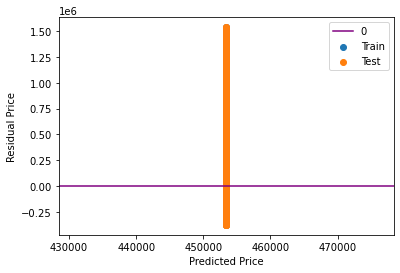

QQ Plot of residuals:


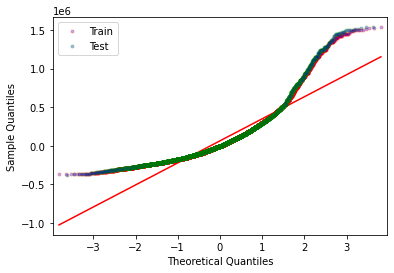

In [505]:
evaluate(y_train, y_test, baseline_train_pred, baseline_test_pred)

### Shit model

In [242]:
def smols(X,y,cols=None):
    Xcol = X[cols]
    shmod = sm.OLS(endog=y, exog=sm.add_constant(Xcol)).fit()
    return shmod

In [243]:
cols = ['sqft_living_log']
smols(X_train,y_train,cols).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:05:08   Log-Likelihood:                -6655.2
No. Observations:               14568   AIC:                         1.331e+04
Df Residuals:                   14566   BIC:                         1.333e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.0715      0.057    123.268      0.000       6.959       7.184
sqft_living_log     0.7900      0.008    103.930      0.000       0.775       0.805
==============================================================================
Omnibus:                      124.409   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.674
Skew:                           0.025   Prob(JB):                     1.12e-18
Kurtosis:                       2.634   Cond. No.                         139.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [244]:
def linpreds(X_tr_scaled, y_tr, X_te_scaled):
    '''
    Uses Linear Regression to generate output predictions given training and test inputs.
    Arguments:
    X_tr_scaled - dataframe
        Input variables and values for the training set
    y_tr - array-like
        Actual values for output variable, for the training set
    X_te_scaled - dataframe
        Input variables and values for the test set
    Returns:
    Output (y) prediction arrays:
        train, test
    '''
    lr = LinearRegression()
    lr.fit(X_tr_scaled, y_tr)
    return lr.predict(X_tr_scaled), lr.predict(X_te_scaled)

In [247]:
X_train_scaled.columns

Index(['sqft_living', 'sqft_living_log', 'sqft_lot', 'sqft_lot_log',
       'sqft_above', 'sqft_above_log', 'sqft_basement', 'bedrooms',
       'bathrooms', 'floors', 'Cond_Ave', 'Cond_Good', 'Cond_Poor',
       'G_Above_Ave', 'G_Excellent', 'G_Low'],
      dtype='object')

In [253]:
smols(X_train_scaled,y_train,\
      cols=['sqft_living_log']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:24:49   Log-Likelihood:                -6655.2
No. Observations:               14568   AIC:                         1.331e+04
Df Residuals:                   14566   BIC:                         1.333e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0246      0.003   4114.038      0.000      13.018      13.031
sqft_living_log     0.3290      0.003    103.930      0.000       0.323       0.335
==============================================================================
Omnibus:                      124.409   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.674
Skew:                           0.025   Prob(JB):                     1.12e-18
Kurtosis:                       2.634   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
smols(X_train_scaled,y_train,\
      cols=['sqft_living_log','G_Above_Ave', 'G_Excellent', 'G_Low']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     2905.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:08:00   Log-Likelihood:                -5657.1
No. Observations:               14568   AIC:                         1.133e+04
Df Residuals:                   14562   BIC:                         1.137e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0246      0.003   4405.194      0.000      13.019      13.030
sqft_living_log     0.2080      0.005     41.801      0.000       0.198       0.218
bathrooms          -0.0135      0.005     -2.897      0.004      -0.023      -0.004
G_Above_Ave         0.1201      0.004     32.476      0.000       0.113       0.127
G_Excellent         0.1547      0.004     41.468      0.000       0.147       0.162
G_Low              -0.0439      0.003    -13.005      0.000      -0.051      -0.037
==============================================================================
Omnibus:                       40.510   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.669
Skew:                           0.063   Prob(JB):                     2.96e-08
Kurtosis:                       2.796   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [508]:
data.columns

Index(['price', 'price_log', 'sqft_living', 'sqft_living_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_above', 'sqft_above_log', 'has_basement',
       'bedrooms', 'bathrooms', 'floors', 'Cond_Good', 'Cond_Poor',
       'G_Above_Ave', 'G_Excellent', 'G_Low', 'bedroom/sqft_living_log',
       'bathrooms/sqft_living_log', 'floors/sqft_living_log',
       'has_basement*sqft_living_log', 'sqft_living_log/sqft_lot_log'],
      dtype='object')

In [509]:
data

,price,price_log,sqft_living,sqft_living_log,sqft_lot,sqft_lot_log,sqft_above,sqft_above_log,has_basement,bedrooms,...,Cond_Good,Cond_Poor,G_Above_Ave,G_Excellent,G_Low,bedroom/sqft_living_log,bathrooms/sqft_living_log,floors/sqft_living_log,has_basement*sqft_living_log,sqft_living_log/sqft_lot_log
0,221900.0,12.309982,1180,7.073270,5650,8.639411,1180,7.073270,0,3,...,0.0,0.0,0.0,0.0,0.0,0.424132,0.141377,0.141377,0.000000,0.818721
1,538000.0,13.195614,2570,7.851661,7242,8.887653,2170,7.682482,1,3,...,0.0,0.0,0.0,0.0,0.0,0.382085,0.286564,0.254723,7.851661,0.883435
2,180000.0,12.100712,770,6.646391,10000,9.210340,770,6.646391,0,2,...,0.0,0.0,0.0,0.0,1.0,0.300915,0.150458,0.150458,0.000000,0.721623
3,604000.0,13.311329,1960,7.580700,5000,8.517193,1050,6.956545,1,4,...,1.0,0.0,0.0,0.0,0.0,0.527656,0.395742,0.131914,7.580700,0.890047
4,510000.0,13.142166,1680,7.426549,8080,8.997147,1680,7.426549,0,3,...,0.0,0.0,1.0,0.0,0.0,0.403956,0.269304,0.134652,0.000000,0.825434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21948,360000.0,12.793859,1530,7.333023,1131,7.030857,1530,7.333023,0,3,...,0.0,0.0,1.0,0.0,0.0,0.409108,0.340924,0.409108,0.000000,1.042977
21949,400000.0,12.899220,2310,7.745003,5813,8.667852,2310,7.745003,0,4,...,0.0,0.0,1.0,0.0,0.0,0.516462,0.322789,0.258231,0.000000,0.893532
21950,402101.0,12.904459,1020,6.927558,1350,7.207860,1020,6.927558,0,2,...,0.0,0.0,0.0,0.0,0.0,0.288702,0.108263,0.288702,0.000000,0.961112
21951,400000.0,12.899220,1600,7.377759,2388,7.778211,1600,7.377759,0,3,...,0.0,0.0,1.0,0.0,0.0,0.406628,0.338856,0.271085,0.000000,0.948516


In [263]:
smols(X_train_scaled,y_train,\
      cols=['sqft_living_log','G_Above_Ave', 'G_Excellent', 'G_Low',
           'bedroom/sqft_living_log', 'bathrooms/sqft_living_log',
           'floors/sqft_living_log', 'sqft_basement/sqft_living_log',
           'sqft_living_log/sqft_lot_log']).summary()

MissingDataError: exog contains inf or nans

In [ ]:
X_tr1, X_te1 = X_train_scaled[['sqft_living_log']], X_test_scaled[['sqft_living_log']]
X_tr2, X_te2 = X_train_scaled[['sqft_living_log','bathrooms']],\
               X_test_scaled[['sqft_living_log','bathrooms']]
X_tr3, X_te3 = X_train_scaled[['sqft_living_log','bathrooms','bedrooms']],\
               X_test_scaled[['sqft_living_log','bathrooms','bedrooms']]
X_tr4, X_te4 = X_train_scaled[['sqft_living_log','bathrooms','bedrooms','floors']],\
               X_test_scaled[['sqft_living_log','bathrooms','bedrooms','floors']]

trp1, tep1 = linpreds(X_tr1, y_train, X_te1)
trp2, tep2 = linpreds(X_tr2, y_train, X_te2)
trp3, tep3 = linpreds(X_tr3, y_train, X_te3)
trp4, tep4 = linpreds(X_tr4, y_train, X_te4)

In [ ]:
evaluate(y_train, y_test, trp4, tep4)

In [ ]:
evaluate(y_train, y_test, trp3, tep3)

In [ ]:
evaluate(y_train, y_test, trp2, tep2)

In [ ]:
evaluate(y_train, y_test, trp1, tep1)

### Polynomial Features
As seen above, we get only modest improvements in R2 and error calculations, but let's see if we can improve this with interaction terms.

In [ ]:
datantot.columns

In [ ]:
Xpf = datantot.drop(columns=['price_log','price','id','sqft_basement','sqft_living', 'sqft_lot', 'sqft_above'])

pf = PolynomialFeatures(degree=2)
pf.fit(Xpf)
Xpdf = pd.DataFrame(pf.transform(Xpf),\
                   columns=pf.get_feature_names(input_features=Xpf.columns))

Xpf_train, Xpf_test, ypf_train, ypf_test = \
train_test_split(Xpdf, datantot['price_log'], test_size=0.33, random_state=42)

In [ ]:
pfscaler = StandardScaler()
pfscaler.fit(Xpf_train)
Xpf_train_scaled = pfscaler.transform(Xpf_train)
Xpf_test_scaled = pfscaler.transform(Xpf_test)
Xpf_train_scaled = pd.DataFrame(Xpf_train_scaled, columns=Xpf_train.columns, index=Xpf_train.index)
Xpf_test_scaled = pd.DataFrame(Xpf_test_scaled, columns=Xpf_test.columns, index=Xpf_test.index)

In [ ]:
pftrp1, pftep1 = linpreds(Xpf_train_scaled, ypf_train, Xpf_test_scaled)

In [ ]:
evaluate(ypf_train, ypf_test, pftrp1, pftep1)

In [ ]:
Xpf_train_scaled.columns

In [ ]:
smXpf = Xpf_train_scaled.drop(columns='1')
pfsm = smols(smXpf, ypf_train, cols=smXpf.columns)
pfsm_df = pfsm.params.reset_index()
pfsm_df = pfsm_df.merge(pfsm.pvalues.reset_index(), on='index')
pfsm_df = pfsm_df.set_index('index')
pfsm_df.columns = ['coef','p_value']

In [ ]:
pfsm_df.sort_values('coef', ascending=False)

In [ ]:
pfsm_df.sort_values('p_value', ascending=False)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [ ]:
# code here to prepare your data

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [ ]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
